# Diabetic Retinopathy Detection

## Description

Diabetic retinopathy is the leading cause of blindness in the working-age population of the developed world. It is estimated to affect over 93 million people.

The US Center for Disease Control and Prevention estimates that 29.1 million people in the US have diabetes and the World Health Organization estimates that 347 million people have the disease worldwide. Diabetic Retinopathy (DR) is an eye disease associated with long-standing diabetes. Around 40% to 45% of Americans with diabetes have some stage of the disease. Progression to vision impairment can be slowed or averted if DR is detected in time, however this can be difficult as the disease often shows few symptoms until it is too late to provide effective treatment.

Currently, detecting DR is a time-consuming and manual process that requires a trained clinician to examine and evaluate digital color fundus photographs of the retina. By the time human readers submit their reviews, often a day or two later, the delayed results lead to lost follow up, miscommunication, and delayed treatment.

Clinicians can identify DR by the presence of lesions associated with the vascular abnormalities caused by the disease. While this approach is effective, its resource demands are high. The expertise and equipment required are often lacking in areas where the rate of diabetes in local populations is high and DR detection is most needed. As the number of individuals with diabetes continues to grow, the infrastructure needed to prevent blindness due to DR will become even more insufficient.

The need for a comprehensive and automated method of DR screening has long been recognized, and previous efforts have made good progress using image classification, pattern recognition, and machine learning. With color fundus photography as input, the goal of this competition is to push an automated detection system to the limit of what is possible – ideally resulting in models with realistic clinical potential. The winning models will be open sourced to maximize the impact such a model can have on improving DR detection.

## Data Description

You are provided with a large set of high-resolution retina images taken under a variety of imaging conditions. A left and right field is provided for every subject. Images are labeled with a subject id as well as either left or right (e.g. 1_left.jpeg is the left eye of patient id 1).

A clinician has rated the presence of diabetic retinopathy in each image on a scale of 0 to 4, according to the following scale:

* 0 - No DR

* 1 - Mild

* 2 - Moderate

* 3 - Severe

* 4 - Proliferative DR

## Task 

Your task is to create an automated analysis system capable of assigning a score based on this scale.

The images in the dataset come from different models and types of cameras, which can affect the visual appearance of left vs. right. Some images are shown as one would see the retina anatomically (macula on the left, optic nerve on the right for the right eye). Others are shown as one would see through a microscope condensing lens (i.e. inverted, as one sees in a typical live eye exam). There are generally two ways to tell if an image is inverted:

It is inverted if the macula (the small dark central area) is slightly higher than the midline through the optic nerve. If the macula is lower than the midline of the optic nerve, it's not inverted.
If there is a notch on the side of the image (square, triangle, or circle) then it's not inverted. If there is no notch, it's inverted.
Like any real-world data set, you will encounter noise in both the images and labels. Images may contain artifacts, be out of focus, underexposed, or overexposed. A major aim of this competition is to develop robust algorithms that can function in the presence of noise and variation.

# Importing Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import tensorflow as tf

In [4]:
plt.style.use('seaborn-whitegrid')
sns.set_style('whitegrid')

In [5]:
%matplotlib inline

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
IMG_SIZE = 512
BATCH_SIZE = 32

# Loading Dataset

In [8]:
images_folder = "./gdrive/MyDrive/datasets/Diabetic Retinopathy Detection/images"
labels_path = "./gdrive/MyDrive/datasets/Diabetic Retinopathy Detection/trainLabels.csv"

In [9]:
df = pd.read_csv(labels_path)
df

,image,level
0,84_left,0
1,84_right,0
2,95_left,0
3,95_right,0
4,99_left,3
...,...,...
1422,9996_left,0
1423,9996_right,0
1424,9998_left,0
1425,9998_right,0


In [10]:
conditions = {
    0: "No DR",
    1: "Mild",
    2: "Moderate",
    3: "Severe",
    4: "Proliferative DR"
}

# Data Cleaning & Manipulation

In [11]:
df["which_eye"] = df["image"].str.split("_").apply(lambda x: x[1]).astype("category")
df["level"] = df["level"].replace(conditions)
df["level"] = pd.Categorical(values=df["level"],
                             categories=conditions.values(),
                             ordered=True)
df.head()

,image,level,which_eye
0,84_left,No DR,left
1,84_right,No DR,right
2,95_left,No DR,left
3,95_right,No DR,right
4,99_left,Severe,left


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1427 entries, 0 to 1426
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   image      1427 non-null   object  
 1   level      1427 non-null   category
 2   which_eye  1427 non-null   category
dtypes: category(2), object(1)
memory usage: 14.3+ KB


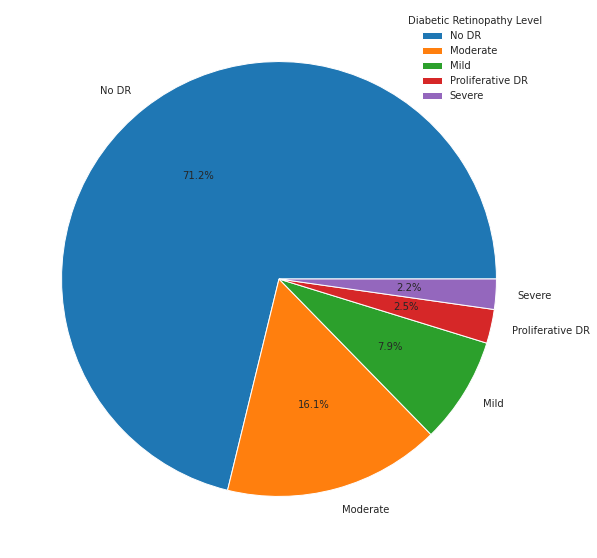

In [13]:
x = df["level"].value_counts()

fig, ax = plt.subplots(figsize=(10, 10))
ax.pie(
    x=x.values,
    labels=x.index,
    autopct="%.1f%%",
)
ax.legend(labels=x.index, title="Diabetic Retinopathy Level")
fig.show()

# Data Preparation

In [14]:
def load_image(path):
    bytes_img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(bytes_img, channels=3)
    return img


In [15]:
from tensorflow.keras.utils import image_dataset_from_directory

In [16]:
ds_train = image_dataset_from_directory(directory=images_folder,
                                        validation_split=0.2,
                                        subset="training",
                                        batch_size=BATCH_SIZE,
                                        seed=42,
                                        label_mode="categorical"
                                        )

ds_val = image_dataset_from_directory(directory=images_folder, 
                                      validation_split=0.2, 
                                      subset="validation",
                                      batch_size=BATCH_SIZE,
                                      seed=42,
                                      label_mode="categorical"
                                      )

Found 1426 files belonging to 5 classes.
Using 1141 files for training.
Found 1426 files belonging to 5 classes.
Using 285 files for validation.


In [17]:
from tensorflow.keras.models import Sequential

In [18]:
from tensorflow.keras.layers import Resizing, Rescaling
from tensorflow.keras.layers import RandomContrast, RandomFlip, RandomRotation
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten
from tensorflow.keras.metrics import AUC, Accuracy, Precision, Recall, TruePositives, TrueNegatives, FalsePositives, FalseNegatives

In [19]:
def create_model():

    preprocessing = Sequential()
    preprocessing.add(Resizing(IMG_SIZE, IMG_SIZE))
    preprocessing.add(Rescaling(1./255))

    augmentation = Sequential()
    augmentation.add(RandomContrast(factor=0.5))
    augmentation.add(RandomFlip(mode="horizontal_and_vertical"))
    augmentation.add(RandomRotation(factor=0.3))

    model = Sequential()
    model.add(preprocessing)
    model.add(augmentation)

    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(264,264,3)))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=[AUC(name="auc"),
                           AUC(name='prc', curve='PR'),
                           Recall(name="recall"),
                           Precision(name="precision"),
                           Accuracy(name="accuracy"),
                           TruePositives(name="TP"),
                           TrueNegatives(name="TN"),
                           FalsePositives(name="FP"),
                           FalseNegatives(name="FN")])
    return model

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

ds_train = ds_train.cache().prefetch(buffer_size=AUTOTUNE)
ds_val = ds_val.cache().prefetch(buffer_size=AUTOTUNE)

In [21]:
model = create_model()
history = model.fit(ds_train,
                    verbose=2,
                    validation_data=ds_val,
                    epochs=5)

Epoch 1/5
36/36 - 2737s - loss: 1.4847 - auc: 0.7447 - prc: 0.4395 - recall: 0.0929 - precision: 0.6272 - accuracy: 0.0000e+00 - TP: 106.0000 - TN: 4501.0000 - FP: 63.0000 - FN: 1035.0000 - val_loss: 1.3156 - val_auc: 0.8877 - val_prc: 0.6633 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_TP: 0.0000e+00 - val_TN: 1140.0000 - val_FP: 0.0000e+00 - val_FN: 285.0000
Epoch 2/5
36/36 - 2597s - loss: 1.2442 - auc: 0.8172 - prc: 0.5637 - recall: 0.2489 - precision: 0.7065 - accuracy: 0.0000e+00 - TP: 284.0000 - TN: 4446.0000 - FP: 118.0000 - FN: 857.0000 - val_loss: 1.0009 - val_auc: 0.8877 - val_prc: 0.6633 - val_recall: 0.7368 - val_precision: 0.7368 - val_accuracy: 0.0000e+00 - val_TP: 210.0000 - val_TN: 1065.0000 - val_FP: 75.0000 - val_FN: 75.0000
Epoch 3/5
36/36 - 2595s - loss: 1.1765 - auc: 0.8330 - prc: 0.5857 - recall: 0.3295 - precision: 0.6976 - accuracy: 0.0000e+00 - TP: 376.0000 - TN: 4401.0000 - FP: 163.0000 - FN: 765.0000 - val_loss: 0.9849

In [22]:
def get_sensitivity(tps, fns):
    # Sensitivity = (True Positive)/(True Positive + False Negative)
     return [tp / (tp + fn) for tp, fn in zip(tps, fns)]

def get_specificity(tns, fps):
    # Specificity = (True Negative)/(True Negative + False Positive)
    return [tn / (tn + fp) for tn, fp in zip(tns, fps)]

In [23]:
sensitivity = get_sensitivity(history.history["TP"], history.history["FN"])
val_sensitivity = get_sensitivity(history.history["val_TP"], history.history["val_FN"])

specificity = get_specificity(history.history["TN"], history.history["FP"])
val_specificity = get_specificity(history.history["val_TN"], history.history["val_FP"])

In [24]:
metrics = {
    "loss": [history.history["loss"], history.history["val_loss"]],
    "auc": [history.history["auc"], history.history["val_auc"]],
    "prc": [history.history["prc"], history.history["val_prc"]],
    "recall": [history.history["recall"], history.history["val_recall"]],
    "precision": [history.history["precision"], history.history["val_precision"]],
    "accuracy": [history.history["accuracy"], history.history["val_accuracy"]],
    "sensitivity": [sensitivity, val_sensitivity],
    "specificity": [specificity, val_specificity]
}


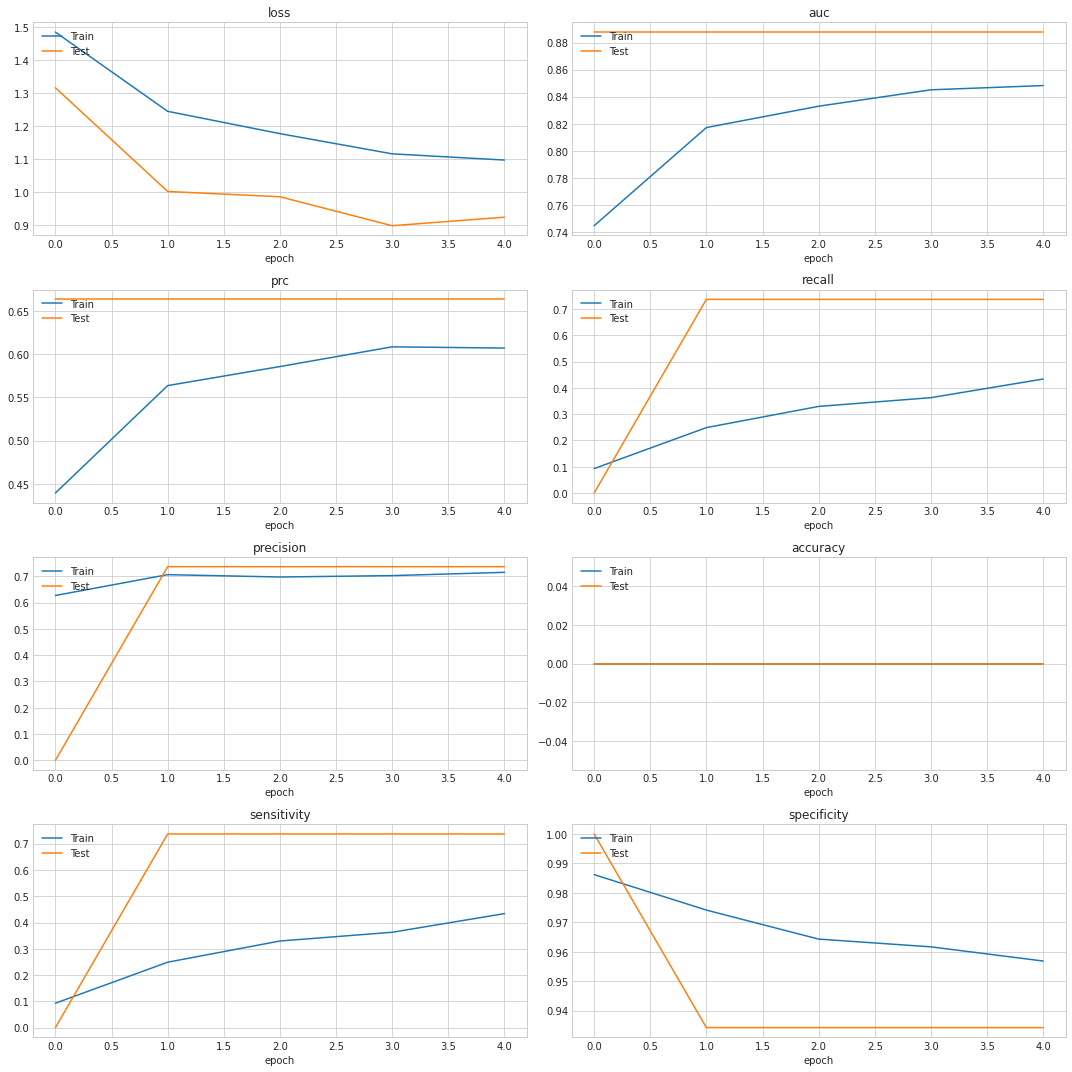

In [25]:
fig, axs = plt.subplots(figsize=(15, 15), ncols=2, nrows=4)

for metric, ax in zip(metrics.items(), axs.flatten()):
    name = metric[0]

    train = metric[1][0]
    test = metric[1][1]

    ax.plot(train)
    ax.plot(test)

    ax.set_title(name)

    ax.set_xlabel("epoch")
    ax.legend(['Train', 'Test'], loc='upper left')

fig.tight_layout()
fig.show()